# Detection with YOLOv5

A majority of this tutorial is adapted from the [YOLOv5 Custom Training Notebook](https://colab.research.google.com/github/roboflow-ai/yolov5-custom-training-tutorial/blob/main/yolov5-custom-training.ipynb) and this [Paperspace Blog](https://blog.paperspace.com/train-yolov5-custom-data/).

## Install Requirements

In [1]:
%%script false --no-raise-error # comment out this line to run this cell

!git clone https://github.com/ultralytics/yolov5 ../../external/yolov5
!pip install -qr ../../external/yolov5/requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

## Assemble Our Dataset

### Convert the Annotations into the YOLO v5 Format

In this part, we convert annotations into the format expected by YOLO v5.

Annotations for the SoccerTrack dataset are stored in the SoccerTrack format which is primarily for the purpose of tracking.

<img src="https://soccertrack.readthedocs.io/en/latest/_images/soccertrack_dataframe.png" width="640"/>


Below is an example of the SoccerTrack format.

* One row per Multiple objects
* Each object has class bb_left, bb_top, bb_width, bb_height, conf and so on..
* Box coordinates are not normalized
* Each object can be identified by the TeamID and PlayerID

In [3]:
import soccertrack
from soccertrack.logger import show_df, tqdm # This just makes the df viewable in the notebook.

dataset_path = soccertrack.datasets.get_path('top_view')
path_to_csv = sorted(dataset_path.glob('annotations/*.csv'))[0]

bbdf = soccertrack.load_df(path_to_csv)

show_df(bbdf.head())

The torchreid module is not installed. Please install it using the following command:
pip install git+https://github.com/KaiyangZhou/deep-person-reid.git


YOLOv5 expects annotations for each image in form of a .txt file where each line of the text file describes a bounding box. Consider the following image.

<img src="https://blog.paperspace.com/content/images/2021/03/image-25.png" width="640"/>



The annotation file for the image above looks like the following:

<img src="https://blog.paperspace.com/content/images/2021/03/image-26.png" width="640"/>

There are 3 objects in total (2 persons and one tie). Each line represents one of these objects. The specification for each line is as follows.

* One row per object
* Each row is class x_center y_center width height format.
* Box coordinates must be normalized by the dimensions of the image (i.e. have values between 0 and 1)
* Class numbers are zero-indexed (start from 0).

We can convert the annotation into the YOLO v5 format using the `to_yolov5_format` function provided by SoccerTrack.

In [4]:
from pathlib import Path
import numpy as np
from soccertrack import Camera

# Specify where to save the video
save_dir = Path('../../data/yolov5/' )

# Create a camera object to read the width and height of the video
path_to_mp4 = sorted(dataset_path.glob('videos/*.mp4'))[0]
cam = Camera(path_to_mp4)

yolov5_formatted_data = bbdf.to_yolov5_format(save_dir=save_dir, w=cam.frame_width, h=cam.frame_height)

print('Shape of yolov5_formatted_data:', np.array(yolov5_formatted_data).shape)
print('Sample of yolov5_formatted_data:', yolov5_formatted_data[0][:5])
print(f'Contents of {save_dir}:', *[p.name for p in save_dir.iterdir()][:5], '...')

Shape of yolov5_formatted_data: (900, 23, 5)
Sample of yolov5_formatted_data: [[          0     0.21367      0.4956    0.010156    0.018056]
 [          0     0.38633     0.50903    0.010156    0.018056]
 [          0     0.50508     0.49977    0.010156    0.018056]
 [          0     0.49674     0.24653    0.010156    0.018056]
 [          0     0.41315     0.65023    0.010156    0.018056]]
Contents of ../../data/yolov5: 000699.txt 000589.txt 000404.txt 000157.txt 000006.txt ...


We also want to split the video into individual frames. Iterate through each frame with `iter_frames` and save the image file to the appropriate directory.

In [5]:
%%script false --no-raise-error # comment out this line to run this cell

import cv2

for frame_num, frame in enumerate(tqdm(cam.iter_frames())):
    file_path = f'{save_dir}/{frame_num:06d}.png'
    cv2.imwrite(file_path, frame)

## Partition the Dataset

In [6]:
%%script false --no-raise-error # comment out this line to run this cell

from sklearn.model_selection import train_test_split

# Read images and annotations
images = sorted(save_dir.glob('*.png'))
annotations = sorted(save_dir.glob('*.txt'))

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

# Move each file to their respective folder
def move_files_to_folder(files, folder):
    folder.mkdir(exist_ok=True, parents=True)
    for file in files:
        file.rename(folder / file.name)

move_files_to_folder(train_images, save_dir / 'images/train')
move_files_to_folder(val_images, save_dir / 'images/val')
move_files_to_folder(test_images, save_dir / 'images/test')
move_files_to_folder(train_annotations, save_dir / 'labels/train')
move_files_to_folder(val_annotations, save_dir / 'labels/val')
move_files_to_folder(test_annotations, save_dir / 'labels/test')

## Train Our Custom YOLOv5 model

### Data Config File

Details for the dataset you want to train your model on are defined by the data config YAML file. 
The following parameters have to be defined in a data config file:


1. `train`, `test`, and `val`: Locations of train, test, and validation images.
2. `nc`: Number of classes in the dataset.
3. `names`: Names of the classes in the dataset. The index of the classes in this list would be used as an identifier for the class names in the code.

Below we create a new file called `soccertrack_data.yaml` and place it in the `yolov5/data` folder. 

In [7]:
import yaml

dict_file = {
    'train': str((save_dir / 'images/train').absolute()),
    'val': str((save_dir / 'images/val').absolute()),
    'test': str((save_dir / 'images/test').absolute()),
    'nc': 2,
    'names': ['player', 'ball']
}

yaml_path = (save_dir / 'soccertrack_data.yaml').absolute()
with open(yaml_path, 'w') as file:
    documents = yaml.dump(dict_file, file)

### Choosing the Network Architecture

YOLOv5 provides a variety of network architectures. From smallest to largest, they are: `yolov5n`, `yolov5s`, `yolov5m`, `yolov5l`, and `yolov5x`. The larger the network, the more accurate the model, but the slower it will be.

YOLOv5 will automatically download the pre-trained weights for the network architecture you choose.

### Start training the model

Finally, start training the model by running the following command.

In [8]:
%%script false --no-raise-error # comment out this line to run this cell

!python ../../external/yolov5/train.py --img 640 --cfg yolov5s.yaml --batch 4 --epochs 100 --data {yaml_path} 

Since you are running this code in a notebook, it would be better to run the training in a separate terminal. We have provided the scripts necessary to do this in the `scripts` folder.

Run the following command in a terminal to start training the model.

```bash
source scripts/yolov5/train.sh
```

## Inference

## Inference on a single frame

Using cache found in /home/atomscott/.cache/torch/hub/ultralytics_yolov5_master
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

YOLOv5 🚀 2023-7-19 Python-3.10.12 torch-2.0.1 CPU

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


     bbox_left     bbox_top  bbox_width  bbox_height      conf  class
0  2211.968262    56.247498   14.915283    16.861286  0.511356   32.0
1  2269.634766  1376.936279   15.869873    28.308228  0.461718    0.0
2  1613.313843   639.364136   18.035889    17.658752  0.444476   32.0
3  2015.163330    60.617210   14.575562    15.617268  0.419016   32.0
4  2537.582520  1376.423096   18.026123    18.919556  0.346465   33.0
5  2538.199707   539.645752   21.620361    23.530823  0.314750    0.0
6  2419.445068  2074.750977   22.662598    28.198975  0.300002   14.0
7  2459.448975  2104.723145   33.008301    20.299561  0.266608   14.0
8  2313.385254  2093.224365   21.307617    34.508789  0.250093    0.0


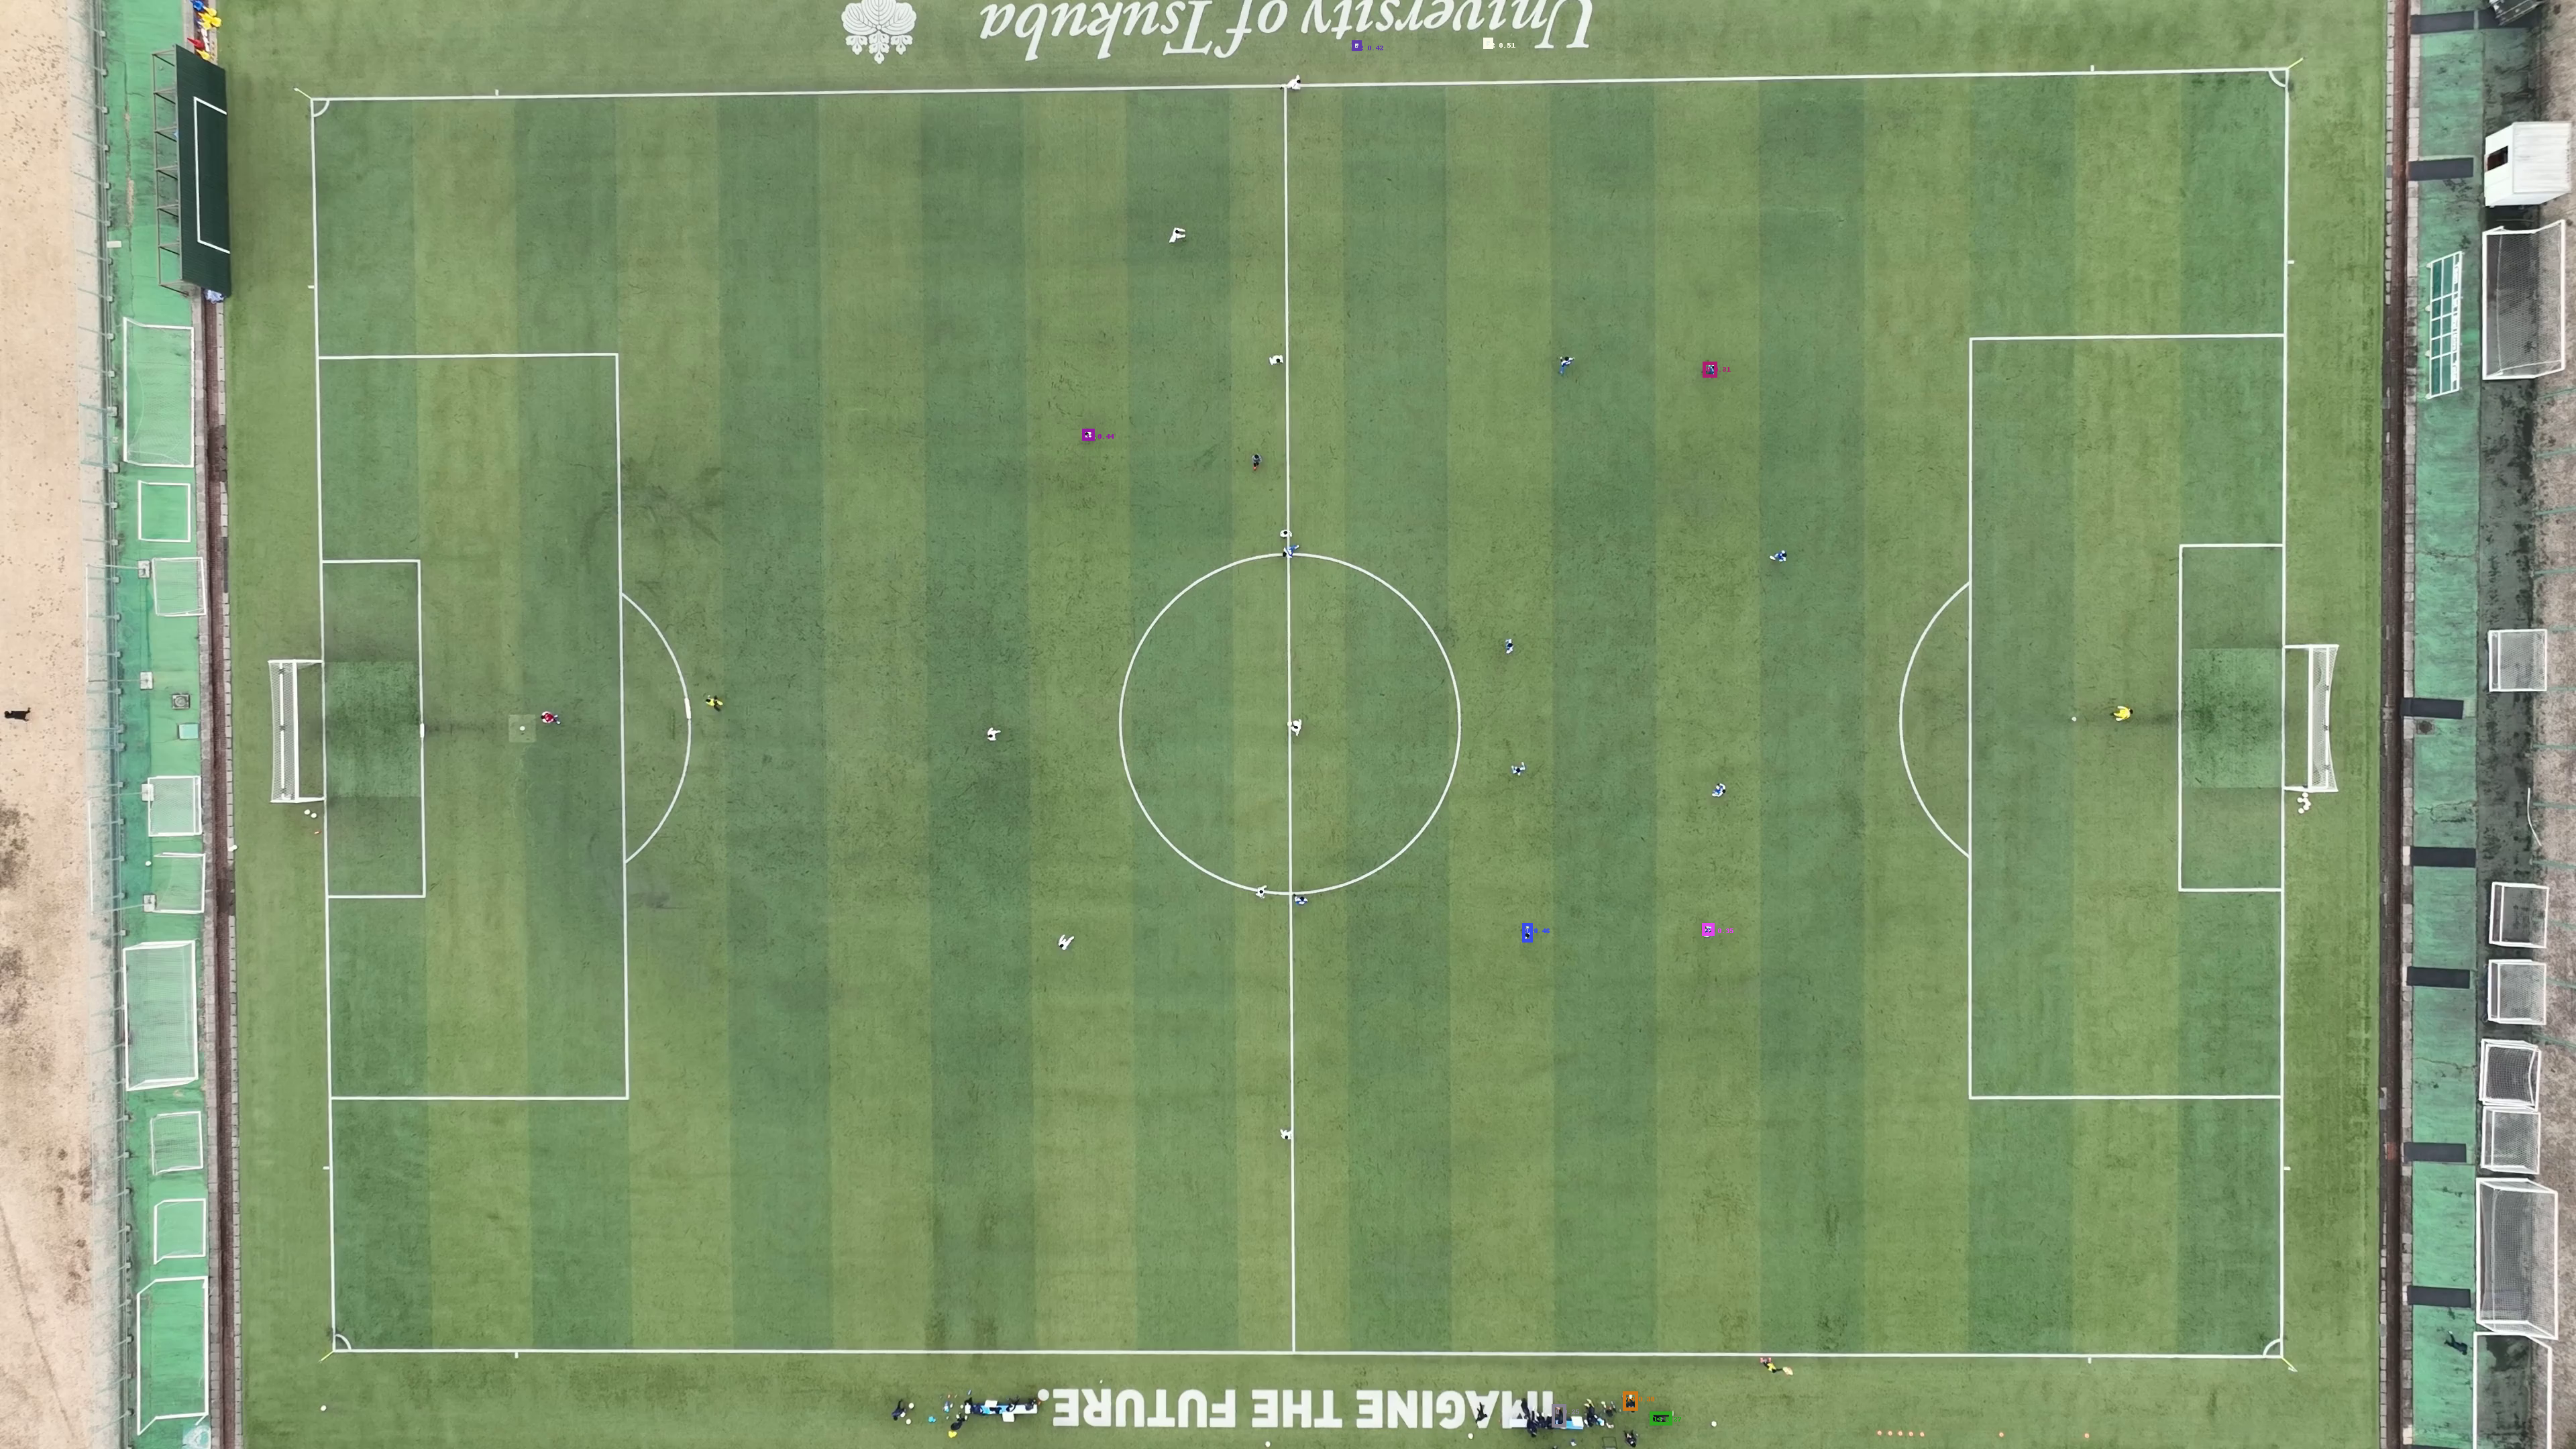

In [9]:
from soccertrack import detection_model
from soccertrack.utils import get_git_root

# let's load the first frame of the video
frame = cam.get_frame(0)

model_config = {'ckpt': 'yolov5x.pt'} # change this to point your model
inference_config = {'augment': True, 'size': 1280}
det_model = detection_model.load('yolov5x', model_config, inference_config=inference_config)

det_result = det_model(frame)[0]

print(det_result.to_df()) # print the results as a dataframe
det_result.show(width=5) # show the bounding boxes on the frame

## Inference on multiple frames

In [10]:
results = []
batch_size = 4
for frames in tqdm(cam[::batch_size]):
    det_result = det_model(frames)
    results += det_result
    
    if len(results) > 10: # let's just run the first 10 frames
        break

  4%|▍         | 10/225 [00:53<19:11,  5.35s/it]


## Evaluation

In [11]:
y_preds = []
y_gts = []
for frame_num, det_result in enumerate(results):
    df_pred = det_result.to_df()
    df_pred["image_name"] = str(frame_num)
    y_preds += df_pred.values.tolist()

    y_gt = bbdf.get_frame(frame_num).to_list_of_tuples_format()[:, :7]
    if len(y_gt) > 0:
        y_gts += list(y_gt)

y_preds = np.array(y_preds, dtype=object)
y_gts = np.array(y_gts, dtype=object)

# treat all classes the same for now
y_preds[:, 5] = 0
y_gts[:, 5] = 0

In [12]:
from soccertrack.metrics import map_score

score = map_score(y_preds, y_gts, iou_threshold=0.1)
print(score)

0.16782579897333996
